# Preprocessing VDJdb data
This notebook shows how data exported from VDJdb \[1\] can be preprocessed for TCRconv. V- and J-genes are required for better performance. Similarly, also other TCR-seq data can be used. Here only human TCR-sequences have been utilized. It is also possible to use TCRs from other organisms, if the amino acid sequences corresponding to their V- and J- genes are obtained from IMGT \[2\]. Here it is shown how the three datasets presented in the paper are constructed.


\[1\] Bagaev, Dmitry V., et al. VDJdb in 2019: database extension, new analysis infrastructure and a T-cell receptor motif compendium." *Nucleic Acids Research* **48.D1** (2020): D1057-D1062. https://vdjdb.cdr3.net \
\[2\] Lefranc, Marie-Paule, et al. "IMGT, the international ImMunoGeneTics information system." *Nucleic acids research* **37.suppl_1** (2009): D1006-D1012. https://www.imgt.org

## Preliminaries

In [1]:
import prep 
import numpy as np

In [2]:
# Optional, use seaborn styles
from seaborn import set_style
set_style('ticks')

In [3]:
# Amino acid and nucleotide sequences corresponding to Vb & Jb and Va & Ja genes
# used for constructing the complete TCR (i.e. V(D)J) sequences based on V- and J-genes and CDR3
protVb,protJb,_,_ = prep.get_protseqs_ntseqs(chain='B')
protVa,protJa,_,_ = prep.get_protseqs_ntseqs(chain='A')

## Data sets with only TCRB-sequences

### VDJdbB-large
Comprehensive TCR$\beta$ dataset with all confidence scores. (min 50 TCR/epitope). Downloaded in January 2021.

In [4]:
# Read sequence data downloaded from VDJdb to dictionary and select epitopes for which there are at least
# min_tcrs_per_epi
datafile = '../db/vdjdb_2021_1_11.tsv' # Exported from VDJdb
tcrs_vdj,epis_u,num_epis = prep.get_tcr_dict(datafile,chain='B', min_tcrs_per_epi=50)

51 epitopes, 32367 TCRs


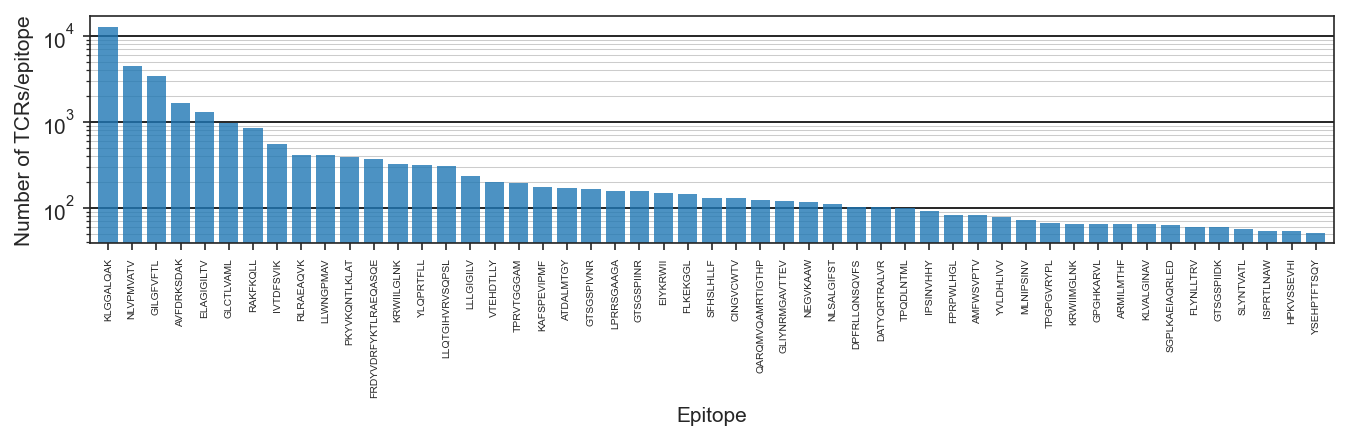

In [5]:
prep.plot_tcrs_per_epitope(epis_u,num_epis)

In [6]:
tcru_dict = prep.get_unique_tcr_dict(tcrs_vdj,'B',vbseqs=protVb,jbseqs=protJb)
print('Number of unique TCRs:', len(tcru_dict))

Number of unique TCRs: 30502


In [7]:
# Write to file
prep.write_data_to_file(tcru_dict,'../training_data/vdjdb-b-large.csv',chain='B')

In [8]:
filename = '../training_data/vdjdb-b-large.csv'
epis = np.loadtxt(filename,usecols=(0),unpack=True,delimiter=',',skiprows=1,comments=None,dtype='str')
epis_u,labels = prep.get_labels(epis)

1.0 
Fold sizes [3051 3051 3050 3050 3050 3050 3050 3050 3050 3050]
Fold size, median: 3050.0, max deviation: 1.0


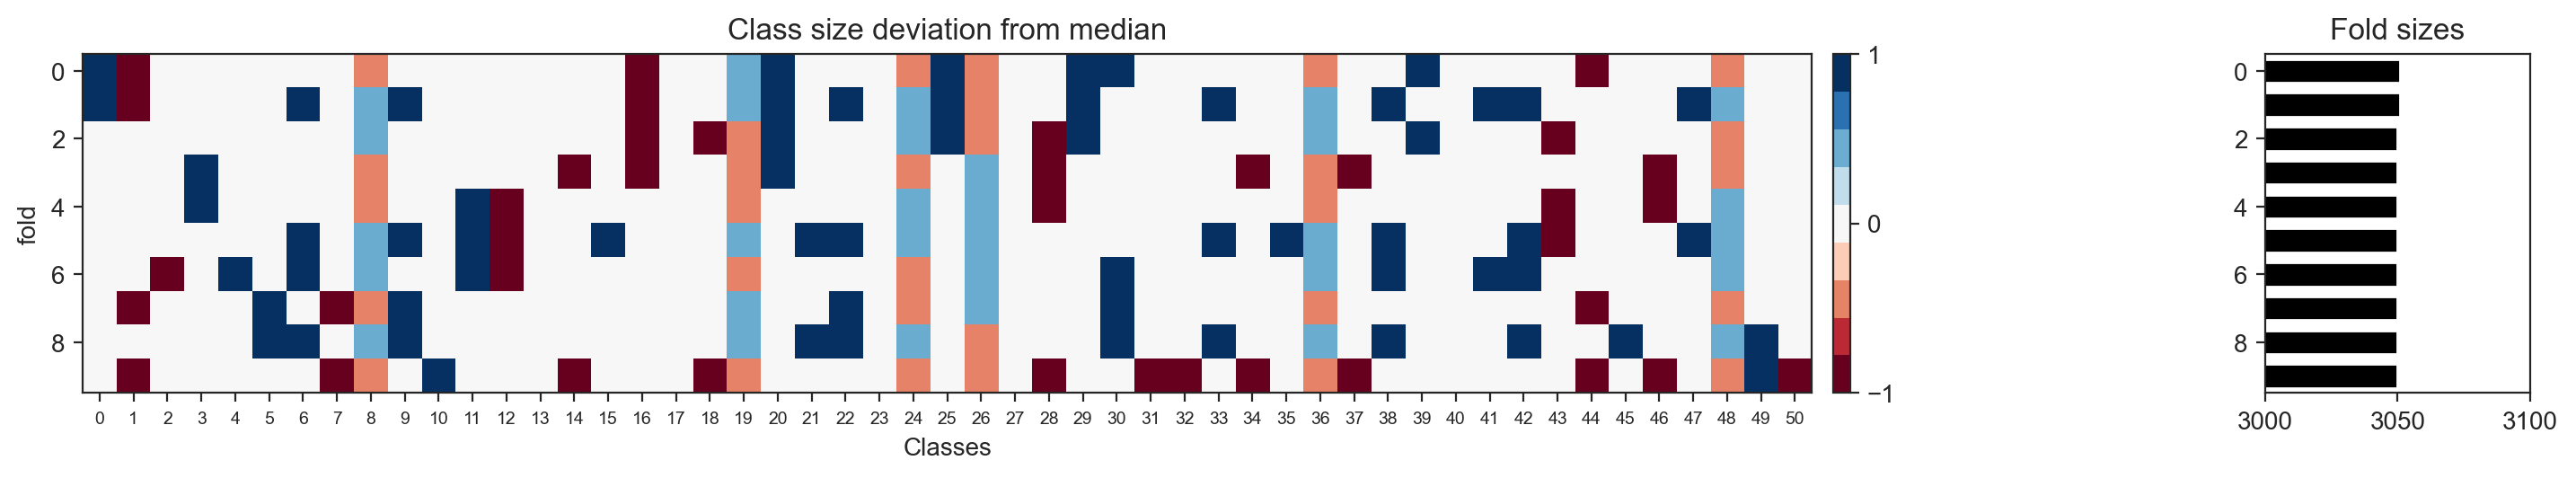

In [9]:
# We'll assign TCRs randomly to each fold so that the number of TCRs recognizing each epitope 
# is as similar as possible. As there are cross-reacting TCRs the number of TCRs in each fold
# can therefore vary. We'll repeat this random assignment multiple times to get also similar fold sizes.
# Finally, we inspect the balance.
maxdev=100
while maxdev>1:
    try:
        folds = prep.get_folds(labels,orderby='xreact',k=10)
    except:
        pass
    tmp = np.asarray([np.sum(folds==i) for i in range(10)])
    med = np.median(tmp)
    maxdev=np.max(np.abs(tmp-med))
    print(maxdev,end=' ')
print('')
print('Fold sizes', tmp)
    
prep.checkFoldBalance(labels,folds,10)

In [10]:
# Save folds, and list of unique epitopes
np.save('../training_data/folds_vdjdb-b-large.npy',folds)
np.save('../training_data/unique_epitopes_vdjdb-b-large.npy',epis_u)

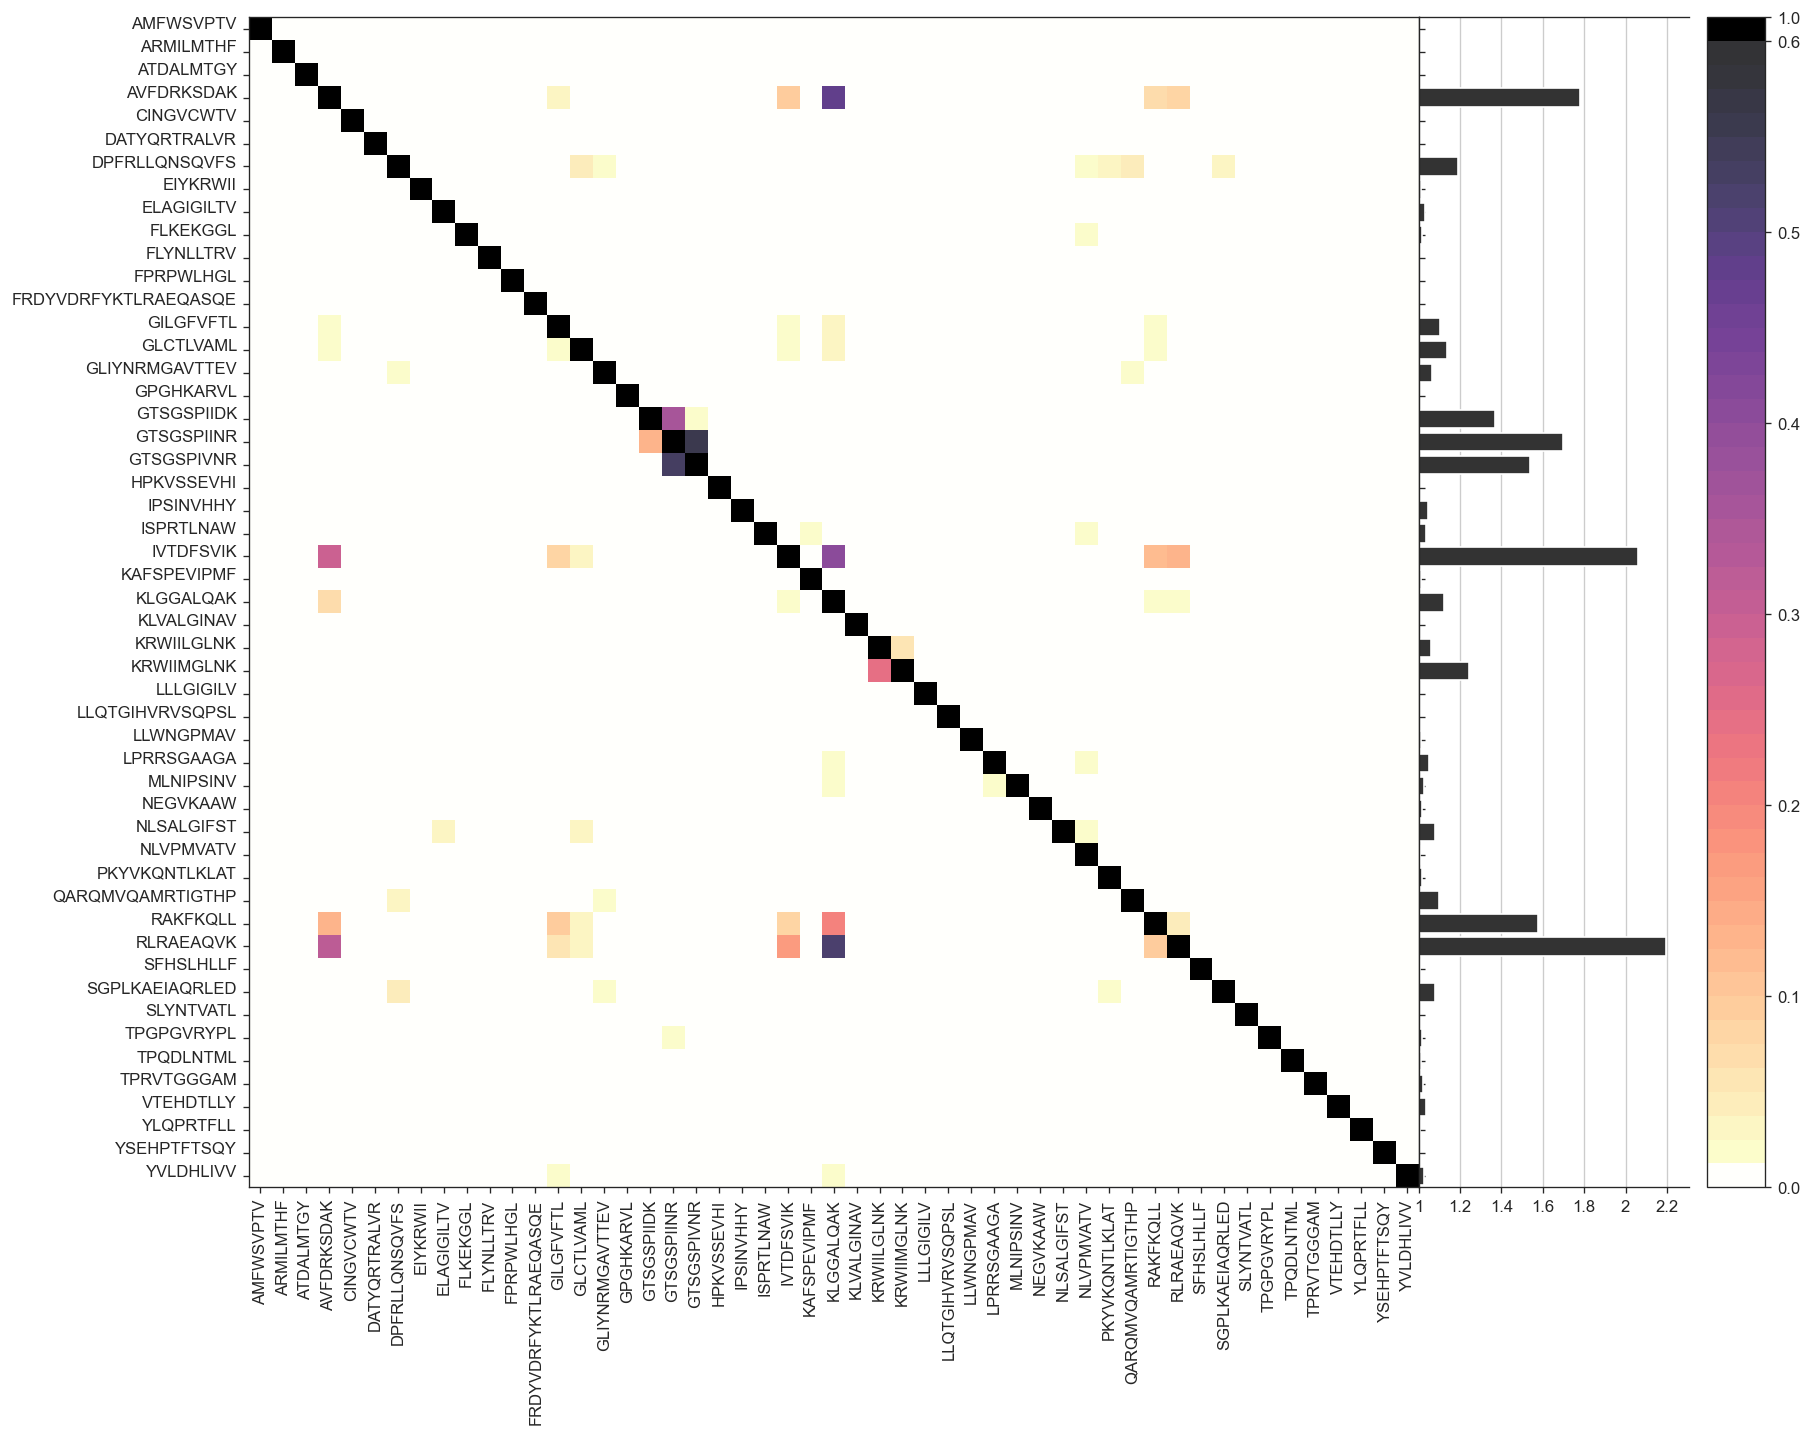

In [11]:
occmat = prep.get_occmat(epis,epis_u)
prep.plot_cross_reactivity(occmat,epis_u,fs=(15,15),dpi=120,bar_lim=2.2) 

### VDJdbB-small
Small high quality dataset (min confidence score 1, min 40 TCR/epitope). Downloaded in January 2021.

In [13]:
# Read sequence data downloaded from VDJdb to dictionary and select epitopes for which there are at least
# min_tcrs_per_epi
tcrs_vdj,epis_u,num_epis = prep.get_tcr_dict('../db/vdjdb_2021_1_11.tsv',chain='B', min_tcrs_per_epi=40,min_score=1)

21 epitopes, 2001 TCRs


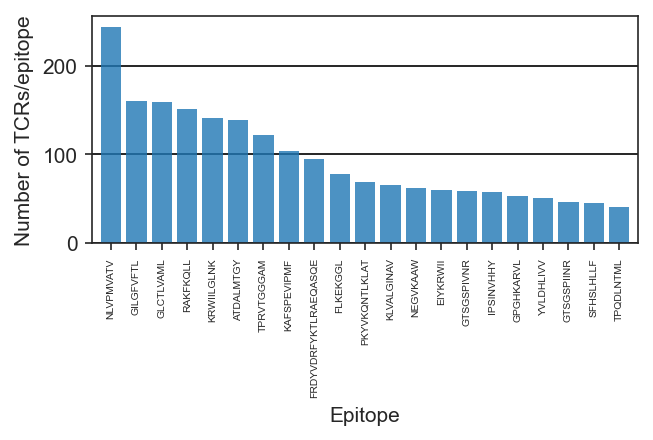

In [14]:
prep.plot_tcrs_per_epitope(epis_u,num_epis,scale='linear')

In [15]:
tcru_dict= prep.get_unique_tcr_dict(tcrs_vdj,chain='B',vbseqs=protVb,jbseqs=protJb)
print('Number of unique TCRs:',len(tcru_dict))

Number of unique TCRs: 1977


In [16]:
# Write to file
prep.write_data_to_file(tcru_dict,'../training_data/vdjdb-b-small.csv',chain='B')

In [17]:
filename = '../training_data/vdjdb-b-small.csv'
epis = np.loadtxt(filename,usecols=(0),unpack=True,delimiter=',',skiprows=1,comments=None,dtype='str')
epis_u,labels = prep.get_labels(epis)

1.0 
Fold sizes [198 198 198 198 198 198 198 197 197 197]
Fold size, median: 198.0, max deviation: 1.0


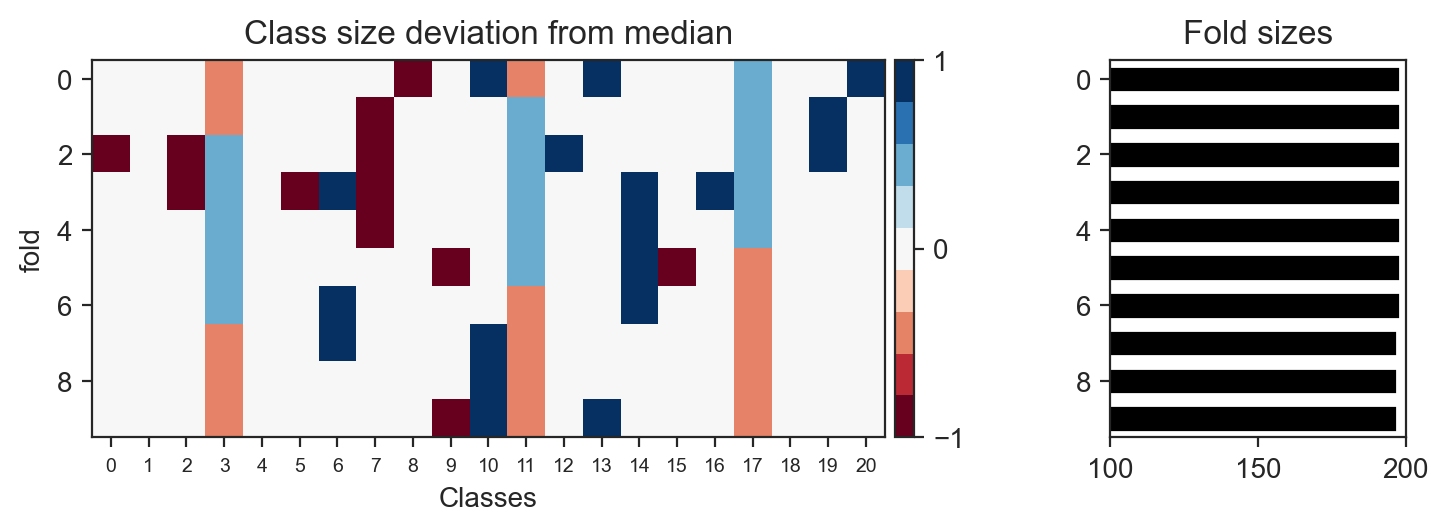

In [18]:
# We'll assign TCRs randomly to each fold so that the number of TCRs recognizing each epitope 
# is as similar as possible. As there are cross-reacting TCRs the number of TCRs in each fold
# can therefore vary. We'll repeat this random assignment multiple times to get also similar fold sizes.
# Finally, we inspect the balance.
maxdev=100
while maxdev>1:
    folds = prep.get_folds(labels,orderby='class-size',k=10)
    tmp = np.asarray([np.sum(folds==i) for i in range(10)])
    med = np.median(tmp)
    maxdev=np.max(np.abs(tmp-med))
    print(maxdev,end=' ')
print('')
print('Fold sizes', tmp)
    
prep.checkFoldBalance(labels,folds,10)

In [19]:
# Save folds, and list of unique epitopes
np.save('../training_data/folds_vdjdb-b-small.npy',folds)
np.save('../training_data/unique_epitopes_vdjdb-b-small.npy',epis_u)

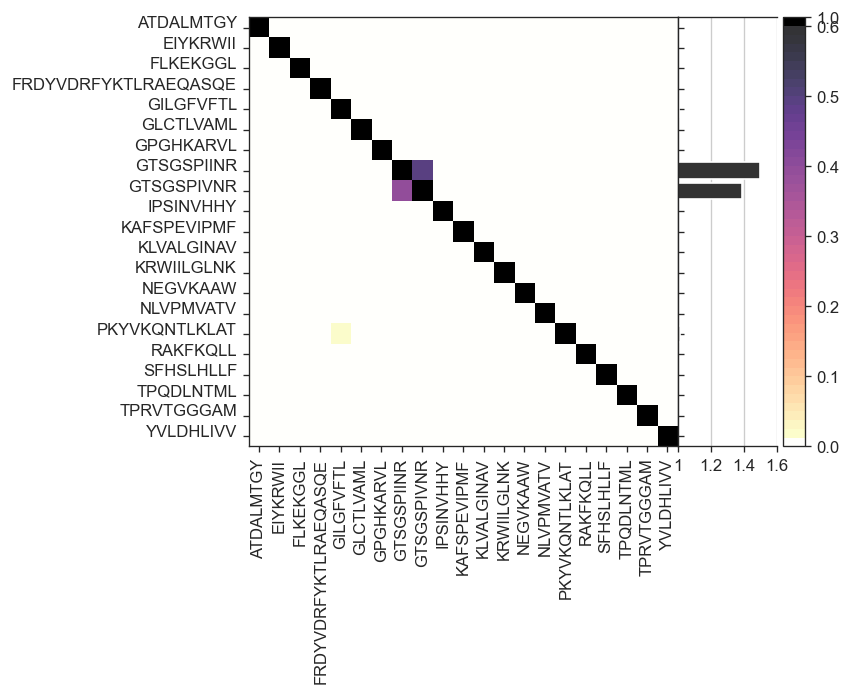

In [20]:
occmat = prep.get_occmat(epis,epis_u)
prep.plot_cross_reactivity(occmat,epis_u,fs=(5.5,5.5),dpi=120,bar_lim=1.6) 

## Data set with paired TCRAB-sequences
### VDJdbAB-large
Comprehensive paired TCR$\alpha\beta$ dataset consisting of TCRs with all confidence scores.

In [22]:
# Read sequence data downloaded from VDJdb to dictionary and select epitopes for which there are at least
# min_tcrs_per_epi
tcrs_vdj,epis_u,num_epis = prep.get_tcr_dict('../db/vdjdb-ab-2021-9.tsv',chain='AB', min_tcrs_per_epi=50)

18 epitopes, 21629 TCRs


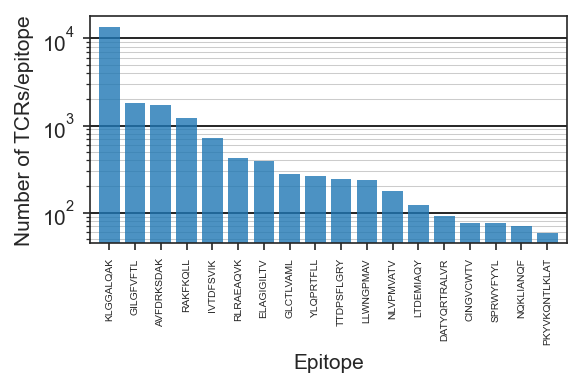

In [23]:
prep.plot_tcrs_per_epitope(epis_u,num_epis)

In [25]:
tcru_dict = prep.get_unique_tcr_dict(tcrs_vdj,'AB',protVb,protJb,protVa,protJa)
print('Number of unique TCRs',len(tcru_dict))

Number of unique TCRs 20200


In [26]:
# Write to file
prep.write_data_to_file(tcru_dict,'../training_data/vdjdb-ab-large.csv',chain='AB')

In [28]:
filename = '../training_data/vdjdb-ab-large.csv'
epis = np.loadtxt(filename,usecols=(0),unpack=True,delimiter=',',skiprows=1,comments=None,dtype='str')
epis_u,labels = prep.get_labels(epis)

17.0 10.0 12.0 17.5 8.0 14.5 14.5 12.5 12.5 8.5 11.5 7.0 10.0 14.5 7.0 3.0 12.0 13.0 17.5 9.0 12.5 13.5 10.0 10.0 12.0 12.0 9.0 10.0 3.0 13.5 12.0 9.5 22.5 8.0 12.0 23.5 14.5 15.5 13.0 7.5 11.5 15.0 17.0 25.0 10.0 6.5 6.0 17.5 19.0 2.0 
Fold sizes [2020 2020 2020 2020 2020 2020 2020 2019 2022 2019]
Fold size, median: 2020.0, max deviation: 2.0


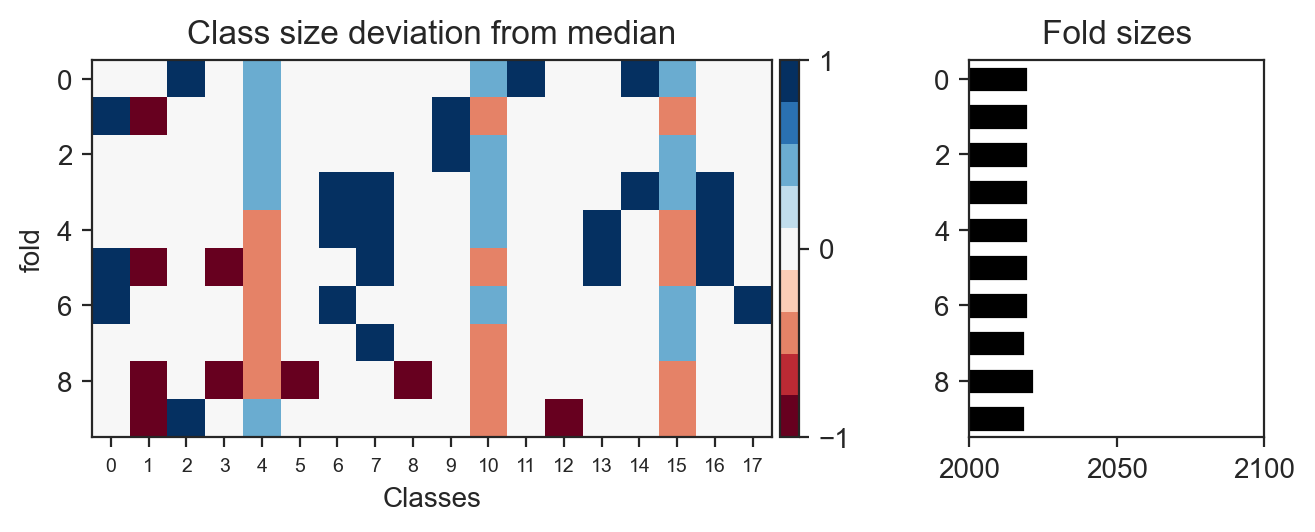

In [30]:
# We'll assign TCRs randomly to each fold so that the number of TCRs recognizing each epitope 
# is as similar as possible. As there are cross-reacting TCRs the number of TCRs in each fold
# can therefore vary. We'll repeat this random assignment multiple times to get also similar fold sizes.
# Finally, we inspect the balance.
maxdev=100
while maxdev>2:
    folds = prep.get_folds(labels,orderby='class-size',k=10)
    tmp = np.asarray([np.sum(folds==i) for i in range(10)])
    med = np.median(tmp)
    maxdev=np.max(np.abs(tmp-med))
    print(maxdev,end=' ')
print('')
print('Fold sizes', tmp)
    
prep.checkFoldBalance(labels,folds,10)

In [32]:
# Save folds, and list of unique epitopes
np.save('../training_data/folds_vdjdb-ab-large.npy',folds)
np.save('../training_data/unique_epitopes_vdjdb-ab-large.npy',epis_u)

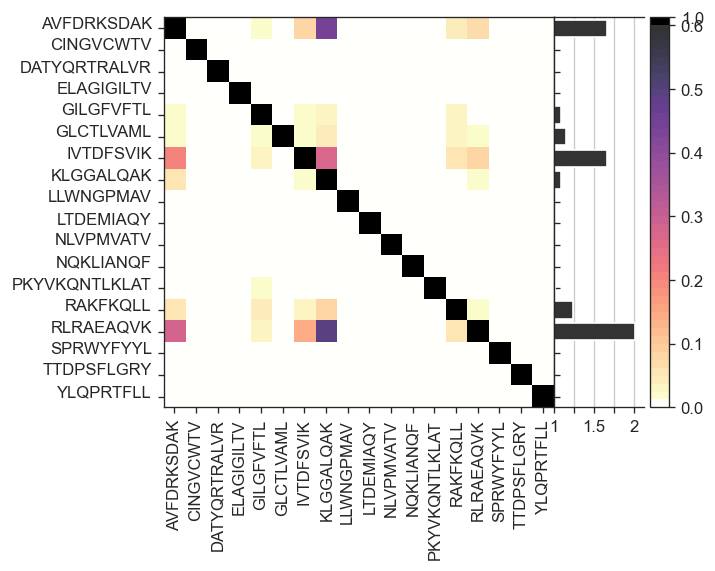

In [33]:
occmat = prep.get_occmat(epis,epis_u)
prep.plot_cross_reactivity(occmat,epis_u,fs=(5,5),dpi=120,bar_lim=2)